# 1\. Load dependency

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import arviz as az
import pymc as pm
import pickle
import seaborn as sns
from tqdm import tqdm
import time
from warnings import filterwarnings
import contextily as cx
import pickle
filterwarnings('ignore')
pd.set_option('display.max_row', 100)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#####
wintering_prefix = 'wintering_model_level_3_May10'
breeding_prefix = 'breeding_model_level_3_May10'
input_final_df_prefix='final_df_model_level_3_May10'


# 2\. Load data

In [3]:
data=pd.read_csv('./8531.csv')
data.shape

(71963, 506)

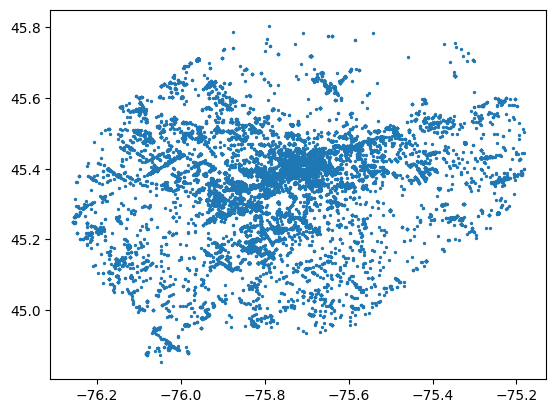

In [4]:
plt.scatter(data.longitude, data.latitude, s=2)
# ax =plt.gca()
# cx.add_basemap(ax, crs='EPSG:4326')
plt.show()

In [5]:
data.latitude.mean(), data.longitude.mean()

(45.35012631018301, -75.77214829329655)

In [6]:
data[data.urban_areas>0].shape, data[data.urban_areas==0].shape


((61639, 506), (10324, 506))

In [7]:
pm.__version__

'5.3.1'

# 3\. Load taxonomy data and filter species list

In [8]:
#### read taxonomy data
ebird = pd.read_csv('/Users/chenyangkang/Desktop/Bird_Functional_Traits/ebird_taxonomy/eBird_Taxonomy_v2021.csv')
avonet_raw = pd.read_csv('/Users/chenyangkang/Desktop/Bird_Functional_Traits/AVONET/AVONET_Raw_Data.csv')
migration = pd.read_csv('/Users/chenyangkang/Desktop/Bird_Functional_Traits/AVONET/AVONET1_BirdLife.csv')
taxon = ebird[['PRIMARY_COM_NAME','SCI_NAME','ORDER1','FAMILY']].drop_duplicates().rename(columns={'SCI_NAME':'Species2_eBird'}).merge(
    avonet_raw[['Species1_BirdLife','Species2_eBird']].drop_duplicates(),
    on='Species2_eBird', how='left'
    ).merge(
    migration[['Species1','Migration']].rename(columns={'Species1':'Species1_BirdLife'}),
    on='Species1_BirdLife', how='left'
    )
taxon = taxon[taxon['Migration']>1]


In [9]:
sp_list = list(data.columns)[list(data.columns).index('entropy')+1:]
sp_list = set(taxon.PRIMARY_COM_NAME.dropna().unique()) & set(sp_list)
sp_list = list(sp_list)
len(sp_list)

278

In [10]:
data[sp_list] = np.where(data[sp_list].fillna(0)>0,1,0)


In [11]:
### sorted sp list
sp_list = [i[0] for i in sorted(data[sp_list].sum().items(), key=lambda x:-x[1])]


# 4\. Filter input data by quality, demography, and migration type

In [12]:
def classify_mig_type(sub):
    
    spring_range = list(np.arange(60,152))
    summer_range = list(np.arange(152,245))
    fall_range = list(np.arange(245,337))
    winter_range = list(np.arange(1,60)) + list(np.arange(337,366))
    
    spring_occ = sub[sub.DOY.isin(spring_range)]['occ'].mean()
    summer_occ = sub[sub.DOY.isin(summer_range)]['occ'].mean()
    fall_occ = sub[sub.DOY.isin(fall_range)]['occ'].mean()
    winter_occ = sub[sub.DOY.isin(winter_range)]['occ'].mean()
    
    
    ###
    flag_list = []
    
    ### passgenger?
    if (spring_occ > winter_occ*2) & (fall_occ > winter_occ*2) & \
            (spring_occ > summer_occ*2) & (fall_occ > summer_occ*2):
        flag_list.append('passenger')
    
    if (winter_occ > summer_occ*2) & (winter_occ > spring_occ) & (winter_occ > fall_occ):
        flag_list.append('wintering')
    
    if (summer_occ > winter_occ*2) & (summer_occ > spring_occ) & (summer_occ > fall_occ):
        flag_list.append('breeding')
    
    return flag_list
        

In [13]:
## calculate cropland
data['cropland'] = data[['cropland_rainfed','cropland_irrigated_post_flooding','mosaic_cropland']].fillna(0).sum(axis=1).values



In [14]:
def assign_spatial_temporal_grid(sub):
    '''
        Spatial-temporal-urban-cropland subsampling. Five dimention. Booooom!
    '''
    lon_array = np.arange(sub.longitude.min(), sub.longitude.max(), 0.05)
    lat_array =  np.arange(sub.latitude.min(), sub.latitude.max(), 0.05)
    doy_array =  np.arange(sub.DOY.min(), sub.DOY.max(), 1)
    sub['lon_lat_doy_urban_crop_grid'] = [str(i)+'_'+str(j)+'_'+str(k)+'_'+str(l)+'_'+str(m) for i,j,k,l,m in zip(np.digitize(sub.longitude, lon_array),
                            np.digitize(sub.latitude, lat_array),
                            np.digitize(sub.DOY, doy_array),
                            np.where(sub.cropland>0,1,0),
                               np.where(sub.urban_areas>0,1,0)
                               )]
    
    return sub


def down_sample(new_sub, samples_each_class=500):
    '''
        If the sample size is still too large -- subsample
    '''
    
    spring_range = list(np.arange(60,152)) + list(range(40,60)) + list(range(152,172))
    summer_range = list(np.arange(152,245)) 
    fall_range = list(np.arange(245,337)) + list(range(225,245)) + list(range(337,357))
    winter_range = list(np.arange(1,60)) + list(np.arange(337,366))
    
    occ_new_sub = new_sub[new_sub.occ==0]
    
    def get_sample_by_seasons(df_, samples_each_class):
        spring_df = df_[df_.DOY.isin(spring_range)]
        fall_df = df_[df_.DOY.isin(fall_range)]
        non_migrating_df = df_[(~df_.DOY.isin(spring_df)) & (~df_.DOY.isin(fall_range))]
        
        sample_size = samples_each_class//3
        
        def get_sample(df,sample_size):
            if len(df)>sample_size:
                df = df.sample(samples_each_class, replace=False) ### if data is abundant, first sample expert's checklist
            else: #.iloc[:samples_each_class,:].sort_values(by='obsvr_species_count', ascending=False)
                df = df.sample(samples_each_class, replace=True)
            return df
        
        new_df_ = pd.concat(
            [get_sample(spring_df, sample_size),
            get_sample(fall_df, sample_size),
            get_sample(non_migrating_df, sample_size)],
            axis=0
        ).reset_index(drop=True)
        
        return new_df_
    
    occ_new_sub = get_sample_by_seasons(new_sub[new_sub.occ==0], samples_each_class)
    non_occ_new_sub = get_sample_by_seasons(new_sub[new_sub.occ>0], samples_each_class)
    return pd.concat([occ_new_sub, non_occ_new_sub], axis=0).reset_index(drop=True)




In [15]:
#### pre-process data: filter species, subsampling
final_list = []
for sp in tqdm(sp_list):
    sp_order = taxon[taxon['PRIMARY_COM_NAME']==sp]['ORDER1'].values[0]
    sub = data[['DOY','year','obsvr_species_count','longitude','latitude','urban_areas','cropland','duration_minutes',sp]]
    sub = sub[(sub.obsvr_species_count>sorted(sub.obsvr_species_count)[int(len(sub)*0.05)]) &\
        (sub.obsvr_species_count<sorted(sub.obsvr_species_count)[int(len(sub)*0.95)])] #### remove outlier birder with extreme bird species count
    sub['Order'] = sp_order
    sub[sp] = sub[sp].fillna(0)
    sub=sub.dropna().rename(columns={sp:'occ'})
    sub['occ'] = np.where(sub['occ']>0,1,0)
    sub['sp'] = sp
    ### filtering
    mean_occ = sub[['DOY','occ']].groupby('DOY').mean()
    if (mean_occ.std()<0.01).values[0]:
        continue
    ### only take summer breeding indiv
    flag_list = classify_mig_type(sub)
    if len(flag_list)>1 or len(flag_list)==0:
        # print('Error: ',flag_list)
        continue
    else:
        flag=flag_list[0]
        
    #### filtering for each year
    sp_df_list = []
    for year in sorted(sub.year.unique()):
        ### filtering
        subsub=sub[sub.year==year]
        if subsub[subsub.occ>0].shape[0]<500:
            continue

        ### resample    
        ### subsample
        subsub = assign_spatial_temporal_grid(subsub)
        subsub = subsub.sample(frac=1, replace=False).groupby('lon_lat_doy_urban_crop_grid').first()
        if len(subsub)>500: #.sort_values(by='obsvr_species_count',ascending=False)
            subsub = down_sample(sub, samples_each_class=250)
        subsub['migration_type'] = flag
        sp_df_list.append(subsub)
    
    if len(sp_df_list)==0:
        continue
    
    print(flag,end='..')
    print(f'{len(sp_df_list)} years samples',end='..')
    final_list.append(pd.concat(sp_df_list, axis=0).reset_index(drop=True))
    
    
print('total species: ',len(final_list))
final_df = pd.concat(final_list, axis=0).reset_index(drop=True)






  1%|          | 2/278 [00:00<00:51,  5.34it/s]

breeding..8 years samples..

  2%|▏         | 6/278 [00:00<00:30,  9.02it/s]

breeding..8 years samples..

  3%|▎         | 8/278 [00:01<00:36,  7.48it/s]

breeding..7 years samples..breeding..7 years samples..

  4%|▎         | 10/278 [00:01<00:53,  5.03it/s]

wintering..8 years samples..

  5%|▍         | 13/278 [00:02<00:43,  6.09it/s]

breeding..6 years samples..

  5%|▌         | 14/278 [00:02<00:48,  5.41it/s]

breeding..6 years samples..

  5%|▌         | 15/278 [00:02<00:53,  4.88it/s]

breeding..6 years samples..

  6%|▋         | 18/278 [00:03<00:43,  5.91it/s]

breeding..6 years samples..

  7%|▋         | 19/278 [00:03<00:53,  4.88it/s]

breeding..6 years samples..

  7%|▋         | 20/278 [00:03<00:55,  4.69it/s]

breeding..5 years samples..

  8%|▊         | 21/278 [00:03<00:58,  4.42it/s]

breeding..6 years samples..

  8%|▊         | 22/278 [00:04<01:00,  4.25it/s]

breeding..6 years samples..

  9%|▉         | 26/278 [00:04<00:38,  6.50it/s]

breeding..6 years samples..

 10%|▉         | 27/278 [00:04<00:43,  5.81it/s]

wintering..5 years samples..

 10%|█         | 28/278 [00:05<00:47,  5.27it/s]

wintering..5 years samples..

 10%|█         | 29/278 [00:05<00:51,  4.84it/s]

breeding..5 years samples..

 11%|█         | 31/278 [00:05<00:44,  5.52it/s]

breeding..5 years samples..

 12%|█▏        | 32/278 [00:05<00:49,  4.92it/s]

breeding..6 years samples..

 12%|█▏        | 34/278 [00:06<00:45,  5.35it/s]

breeding..5 years samples..

 13%|█▎        | 35/278 [00:06<00:47,  5.12it/s]

breeding..4 years samples..

 13%|█▎        | 37/278 [00:06<00:43,  5.54it/s]

wintering..5 years samples..

 14%|█▎        | 38/278 [00:07<00:45,  5.29it/s]

breeding..4 years samples..

 14%|█▍        | 40/278 [00:07<00:39,  5.95it/s]

breeding..4 years samples..

 15%|█▍        | 41/278 [00:07<00:44,  5.35it/s]

breeding..5 years samples..

 15%|█▌        | 42/278 [00:07<00:46,  5.06it/s]

breeding..4 years samples..

 16%|█▌        | 44/278 [00:08<00:39,  6.00it/s]

breeding..4 years samples..

 17%|█▋        | 48/278 [00:08<00:32,  7.14it/s]

breeding..4 years samples..breeding..3 years samples..

 19%|█▉        | 53/278 [00:08<00:19, 11.77it/s]

breeding..3 years samples..

 21%|██        | 58/278 [00:09<00:15, 13.87it/s]

breeding..2 years samples..breeding..1 years samples..

 24%|██▎       | 66/278 [00:09<00:10, 19.31it/s]

breeding..1 years samples..

100%|██████████| 278/278 [00:15<00:00, 17.42it/s]


total species:  33


In [16]:
def reindexing(df):
    df['record_index'] = list(range(len(df)))
    df['year_index'] = pd.factorize(df.year)[0]
    df['order_index'] = pd.factorize(df.Order)[0]
    df['sp_index'] = pd.factorize(df.sp)[0]
    df['duration_minutes'] = (df['duration_minutes'] - df['duration_minutes'].mean())/df['duration_minutes'].std()
    # df['urban_areas'] = (df['urban_areas'] - df['urban_areas'].mean())/df['urban_areas'].std()
    # df['cropland'] = (df['cropland'] - df['cropland'].mean())/df['cropland'].std()
    return df

In [17]:
### save the final input file
final_df.to_csv(f'{input_final_df_prefix}.csv',index=False)

In [18]:
### split by patter
passenger_df = reindexing(
    final_df[final_df.migration_type=='passenger']
    )
breeding_df = reindexing(
    final_df[final_df.migration_type=='breeding']
)
wintering_df = reindexing(
    final_df[final_df.migration_type=='wintering']
)
print(passenger_df.shape,breeding_df.shape, wintering_df.shape)


(0, 16) (214500, 16) (34500, 16)


In [19]:
### save the final input file
wintering_df.to_csv(f'{wintering_prefix}.csv',index=False)
breeding_df.to_csv(f'{breeding_prefix}.csv',index=False)


In [20]:
wintering_df.sp.unique()

array(['Dark-eyed Junco', 'American Tree Sparrow', 'Common Goldeneye',
       'Common Merganser'], dtype=object)

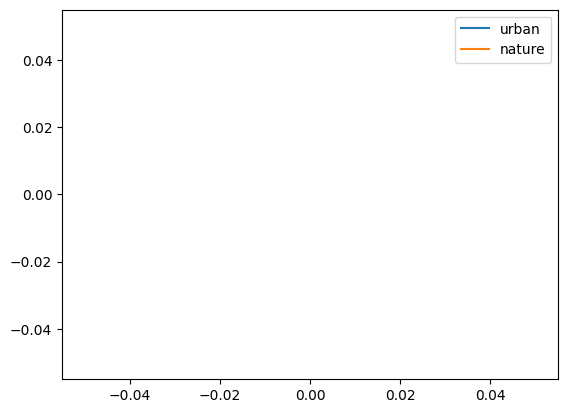

In [21]:
# plt.plot(passenger_df[['DOY','occ']].groupby('DOY').mean().rolling(10).mean())
plt.plot(passenger_df[passenger_df.urban_areas>0][['DOY','occ']].groupby('DOY').mean().rolling(10).mean(), label='urban')
plt.plot(passenger_df[passenger_df.urban_areas==0][['DOY','occ']].groupby('DOY').mean().rolling(10).mean(),label='nature')
plt.legend()
plt.show()



In [22]:
passenger_df

,DOY,year,obsvr_species_count,longitude,latitude,urban_areas,cropland,duration_minutes,occ,Order,sp,migration_type,record_index,year_index,order_index,sp_index


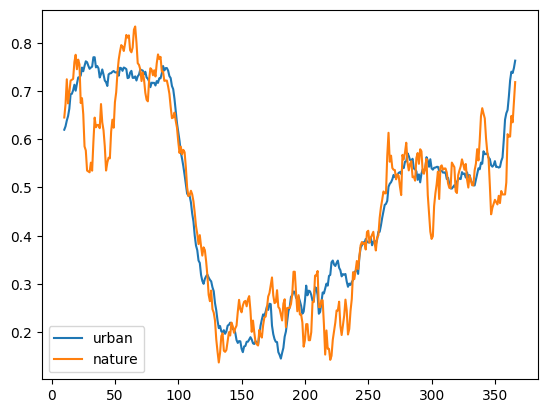

In [23]:

plt.plot(wintering_df[wintering_df.urban_areas>0][['DOY','occ']].groupby('DOY').mean().rolling(10).mean(), label='urban')
plt.plot(wintering_df[wintering_df.urban_areas==0][['DOY','occ']].groupby('DOY').mean().rolling(10).mean(),label='nature')
plt.legend()
plt.show()


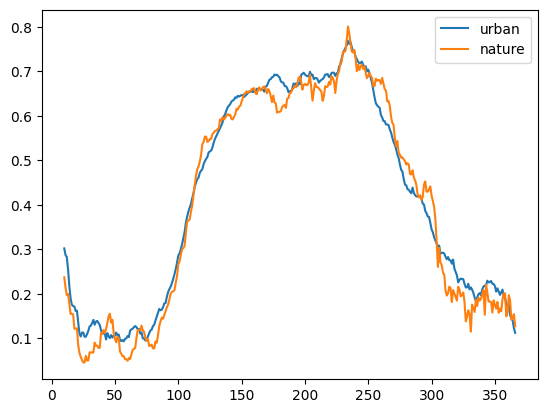

In [24]:

plt.plot(breeding_df[breeding_df.urban_areas>0][['DOY','occ']].groupby('DOY').mean().rolling(10).mean(), label='urban')
plt.plot(breeding_df[breeding_df.urban_areas==0][['DOY','occ']].groupby('DOY').mean().rolling(10).mean(),label='nature')
plt.legend()
plt.show()


In [25]:
breeding_df

,DOY,year,obsvr_species_count,longitude,latitude,urban_areas,cropland,duration_minutes,occ,Order,sp,migration_type,record_index,year_index,order_index,sp_index
0,170,2011,269,-75.644088,45.308187,0.024631,0.226601,0.534981,0,Passeriformes,Song Sparrow,breeding,0,0,0,0
1,145,2016,418,-75.670395,45.409839,0.822335,0.000000,-0.436061,0,Passeriformes,Song Sparrow,breeding,1,1,0,0
2,40,2017,605,-75.702195,45.385642,0.820988,0.009259,0.691601,0,Passeriformes,Song Sparrow,breeding,2,2,0,0
3,116,2016,298,-75.509505,45.391036,0.000000,0.010309,-0.169807,0,Passeriformes,Song Sparrow,breeding,3,1,0,0
4,90,2016,1336,-75.826100,45.179230,0.201493,0.044776,-0.764962,0,Passeriformes,Song Sparrow,breeding,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248995,116,2017,1525,-75.840443,45.176543,0.140000,0.020000,0.049460,1,Pelecaniformes,Black-crowned Night-Heron,breeding,214495,2,4,28
248996,224,2016,250,-75.787103,45.327319,0.695167,0.074349,1.004840,1,Pelecaniformes,Black-crowned Night-Heron,breeding,214496,1,4,28
248997,169,2013,1032,-75.612373,45.421859,0.742268,0.065292,-0.717976,1,Pelecaniformes,Black-crowned Night-Heron,breeding,214497,6,4,28
248998,141,2015,1314,-75.859943,45.183561,0.027174,0.010870,-0.514371,1,Pelecaniformes,Black-crowned Night-Heron,breeding,214498,5,4,28


In [26]:
wintering_df

,DOY,year,obsvr_species_count,longitude,latitude,urban_areas,cropland,duration_minutes,occ,Order,sp,migration_type,record_index,year_index,order_index,sp_index
45000,145,2018,854,-76.213660,45.216903,0.111888,0.013986,-0.322624,0,Passeriformes,Dark-eyed Junco,wintering,0,0,0,0
45001,130,2017,327,-75.773928,45.222919,0.053846,0.415385,-0.406832,0,Passeriformes,Dark-eyed Junco,wintering,1,1,0,0
45002,143,2014,673,-75.647173,45.400318,0.784367,0.000000,-0.743664,0,Passeriformes,Dark-eyed Junco,wintering,2,2,0,0
45003,158,2004,261,-75.543709,45.290958,0.098901,0.093407,-0.827872,0,Passeriformes,Dark-eyed Junco,wintering,3,3,0,0
45004,161,2004,261,-75.352150,45.410179,0.000000,0.000000,-0.827872,0,Passeriformes,Dark-eyed Junco,wintering,4,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196495,156,2016,251,-75.860657,45.344937,0.113043,0.056522,0.182625,1,Anseriformes,Common Merganser,wintering,34495,5,1,3
196496,100,2013,1073,-75.820655,45.198893,0.096774,0.580645,0.132100,1,Anseriformes,Common Merganser,wintering,34496,4,1,3
196497,204,2017,546,-75.818882,45.350456,0.381877,0.012945,-0.322624,1,Anseriformes,Common Merganser,wintering,34497,1,1,3
196498,69,2014,127,-75.735921,45.523539,0.003030,0.084848,1.614163,1,Anseriformes,Common Merganser,wintering,34498,2,1,3


# 5\. Spring departure model

## 5\.0 Train test split

In [27]:
from sklearn.model_selection import train_test_split
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for sp in wintering_df.sp.unique():
    sub = wintering_df[wintering_df.sp==sp]
    
    X_train, X_test, y_train, y_test = train_test_split(sub[[i for i in sub.columns if not i=='occ']],
                                                        sub['occ'],test_size=0.2)
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)
    
    
X_train = pd.concat(X_train_list, axis=0)
X_test = pd.concat(X_test_list, axis=0)
y_train = pd.concat(y_train_list, axis=0)
y_test = pd.concat(y_test_list, axis=0)


## 5\.1 Define model

In [85]:
### passenger model
def cumulative_normal(x, mu, sigma, s=np.sqrt(2)):
    return 0.5 + 0.5 * pm.math.erf((x-mu)/(sigma*s))
def neg_inverse_cumulative_normal(x, mu, sigma, s=np.sqrt(2)):
    return -0.5 - 0.5 * pm.math.erf((x-mu)/(sigma*s))

### running

wintering_model = pm.Model()

with wintering_model:
    wintering_model.add_coord("record_index", sorted(wintering_df['record_index'].unique()))
    wintering_model.add_coord("sp_index", sorted(wintering_df['sp_index'].unique()))
    wintering_model.add_coord("year_index", sorted(wintering_df['year_index'].unique()))
    wintering_model.add_coord("order_index", sorted(wintering_df['order_index'].unique()))
    
    
    DOY_obs = pm.Data('DOY_obs',X_train.DOY.values)
    occ_obs = pm.Data('occ_obs',y_train.values)
    urban_areas_obs = pm.Data('urban_areas_obs',X_train.urban_areas.values)
    cropland_obs = pm.Data('cropland_obs',X_train.cropland.values)
    duration_obs = pm.Data('duration_obs',X_train.duration_minutes.values)
    
    sp_index_obs = pm.Data('sp_index_obs', X_train.sp_index.values)
    year_index_obs = pm.Data('year_index_obs', X_train.year_index.values)
    order_to_sp_obs = pm.Data('order_to_sp_obs', X_train[['sp_index','order_index']].drop_duplicates().sort_values(by='sp_index')['order_index'].values)
    
    ### prior
    ## spring departure
    spring_departure_dist_mu_overall = pm.TruncatedNormal('spring_departure_dist_mu_overall', mu=106, sigma=200, lower=20, upper=175)
    spring_departure_dist_mu = pm.Normal('spring_departure_dist_mu', mu=spring_departure_dist_mu_overall, sigma=20, dims=('sp_index','year_index'))
    spring_departure_dist_sigma = pm.HalfNormal('spring_departure_dist_sigma', sigma=10, dims=('sp_index','year_index'))
    
    ## fall arrival
    fall_arrival_dist_mu_overall = pm.TruncatedNormal('fall_arrival_dist_mu_overall', mu=291, sigma=200, lower=175, upper=356)
    fall_arrival_dist_mu = pm.Normal('fall_arrival_dist_mu', mu=fall_arrival_dist_mu_overall, sigma=20, dims=('sp_index','year_index'))
    fall_arrival_dist_sigma = pm.HalfNormal('fall_arrival_dist_sigma', sigma=10, dims=('sp_index','year_index'))
    
    ##### intercept
    beta = pm.Normal('beta', mu=0, sigma=10, dims=('sp_index','year_index'))
    
    #### urban effect   
    spring_departure_urban_effect_overall = pm.Normal('spring_departure_urban_effect_overall', mu=0, sigma=10)
    spring_departure_urban_effect_order_level = pm.Normal('spring_departure_urban_effect_order_level', mu=spring_departure_urban_effect_overall, sigma=10, dims=('order_index'))
    spring_departure_urban_effect = pm.Normal('spring_departure_urban_effect', mu=spring_departure_urban_effect_order_level[order_to_sp_obs], 
                                              sigma=10, dims=('sp_index'))
    fall_arrival_urban_effect_overall = pm.Normal('fall_arrival_urban_effect_overall', mu=0, sigma=10)
    fall_arrival_urban_effect_order_level = pm.Normal('fall_arrival_urban_effect_order_level', mu=fall_arrival_urban_effect_overall, sigma=10, dims=('order_index'))
    fall_arrival_urban_effect = pm.Normal('fall_arrival_urban_effect', mu=fall_arrival_urban_effect_order_level[order_to_sp_obs],
                                          sigma=10, dims=('sp_index'))
    
    #### cropland effect   
    spring_departure_cropland_effect_overall = pm.Normal('spring_departure_cropland_effect_overall', mu=0, sigma=10)
    spring_departure_cropland_effect_order_level = pm.Normal('spring_departure_cropland_effect_order_level', mu=spring_departure_cropland_effect_overall, sigma=10, dims=('order_index'))
    spring_departure_cropland_effect = pm.Normal('spring_departure_cropland_effect', mu=spring_departure_cropland_effect_order_level[order_to_sp_obs], 
                                                 sigma=100, dims=('sp_index'))
    fall_arrival_cropland_effect_overall = pm.Normal('fall_arrival_cropland_effect_overall', mu=0, sigma=10)
    fall_arrival_cropland_effect_order_level = pm.Normal('fall_arrival_cropland_effect_order_level', mu=fall_arrival_cropland_effect_overall, sigma=10, dims=('order_index'))
    fall_arrival_cropland_effect = pm.Normal('fall_arrival_cropland_effect', mu=fall_arrival_cropland_effect_order_level[order_to_sp_obs], 
                                             sigma=10, dims=('sp_index'))
    
    ### duration effect
    duration_effect_slope = pm.HalfNormal('duration_effect_slope', sigma=10, dims=('sp_index'))
    
    #### city effect modification on timing
    modified_spring_departure_dist = spring_departure_dist_mu[sp_index_obs, year_index_obs] + \
                                        spring_departure_urban_effect[sp_index_obs] * urban_areas_obs + \
                                            spring_departure_cropland_effect[sp_index_obs] * cropland_obs
    
    modified_fall_arrival_dist = fall_arrival_dist_mu[sp_index_obs, year_index_obs] + \
                                    fall_arrival_urban_effect[sp_index_obs] * urban_areas_obs + \
                                        fall_arrival_cropland_effect[sp_index_obs] * cropland_obs


    ### scaling factor
    spring_departure_cumulative_effect_factor = pm.Normal('spring_departure_cumulative_effect_factor',mu=0,sigma=1, dims=('sp_index','year_index'))
    fall_arrival_cumulative_effect_factor = pm.Normal('fall_arrival_cumulative_effect_factor',mu=0,sigma=1, dims=('sp_index','year_index'))
    
    
    ### variables times scalers
    duration_effect_on_obs_prob = duration_effect_slope[sp_index_obs] * duration_obs
    spring_departure_effect_on_obs_prob = (neg_inverse_cumulative_normal(x=DOY_obs, 
                              mu=modified_spring_departure_dist, 
                              sigma=spring_departure_dist_sigma[sp_index_obs, year_index_obs]) + 0.5) * spring_departure_cumulative_effect_factor[sp_index_obs, year_index_obs]
 
    
    # ( -pm.math.exp(pm.logcdf(
    #                                                         pm.Normal.dist(mu=modified_spring_departure_dist, 
    #                                                                         sigma=spring_departure_dist_sigma[sp_index_obs, year_index_obs]
    #                                                                         ),
    #                                                         DOY_obs
    #                                                     ))  + 0.5) * spring_departure_cumulative_effect_factor[sp_index_obs, year_index_obs]

        
    fall_arrival_effect_on_obs_prob =  (cumulative_normal(x=DOY_obs, 
                                                         mu=modified_fall_arrival_dist, 
                                                         sigma=fall_arrival_dist_sigma[sp_index_obs, year_index_obs]) - 0.5)* fall_arrival_cumulative_effect_factor[sp_index_obs, year_index_obs]

    
    # ( pm.math.exp(pm.logcdf(
    #                                                         pm.Normal.dist(mu=modified_fall_arrival_dist, 
    #                                                                         sigma=fall_arrival_dist_sigma[sp_index_obs, year_index_obs]
    #                                                                         ),
    #                                                         DOY_obs
    #                                                     ))  - 0.5) * fall_arrival_cumulative_effect_factor[sp_index_obs, year_index_obs]

    
    #
    #### linear term
            
    y0 = beta[sp_index_obs, year_index_obs] + \
            duration_effect_on_obs_prob + \
            spring_departure_effect_on_obs_prob + \
            fall_arrival_effect_on_obs_prob
            
    p_ = pm.math.sigmoid(y0)
    
    y_ = pm.Bernoulli("y_", p_, observed=occ_obs)
    

    

    

In [86]:
def cumulative_normal(x, mu, sigma, s=np.sqrt(2)):
    return 0.5 + 0.5 * pm.math.erf((x-mu)/(sigma*s))

a = cumulative_normal(10, 10,10)
a.eval()

array(0.5)

In [87]:
pm.math.exp(pm.logcdf(
    pm.Normal.dist(mu=0, sigma=1),
    [1,2,4]
)).eval()


array([0.84134475, 0.97724987, 0.99996833])

## 5\.2 Sample chains

In [88]:
import pymc.sampling.jax as pmjax
import jax
import tensorflow_probability.substrates.jax as tfp
jax.scipy.special.erfcx = tfp.math.erfcx
from fastprogress.fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import force_console_behavior
master_bar, progress_bar = force_console_behavior()

with wintering_model:
    idata = pmjax.sample_numpyro_nuts(1000,chains=1,cores=1, tune=1000, progressbar=True)
    
    #  target_accept=0.99,
    #                   chains=2, cores=2, tune=3000, progressbar=True,
    #                     # trace = ['y_']
                      

Compiling...
Compilation time =  0:00:01.708244
Sampling...


warmup:   1%|          | 20/2000 [00:20<42:10,  1.28s/it, 1023 steps of size 1.21e-02. acc. prob=0.69]

In [69]:
with wintering_model:
    post_idata = pm.sample_posterior_predictive(idata)

Sampling: [y_]
INFO:pymc:Sampling: [y_]


## 5\.3 Predict on test data

In [70]:
def pm_predict_winter_model(X_test):
    ### passenger model
    import math
    from scipy.special import expit
    def math_cumulative_normal(x, mu, sigma, s=np.sqrt(2)):
        return 0.5 + 0.5 * math.erf((x-mu)/(sigma*s))
    def math_neg_inverse_cumulative_normal(x, mu, sigma, s=np.sqrt(2)):
        return -0.5 - 0.5 * math.erf((x-mu)/(sigma*s))

    new_DOY_obs = X_test['DOY'].values
    new_sp_index_obs = X_test['sp_index'].values
    new_year_index_obs = X_test['year_index'].values
    new_urban_areas_obs = X_test['urban_areas'].values
    new_cropland_obs = X_test['cropland'].values

    new_beta = np.concatenate(idata.posterior['beta'].values, axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    new_duration_effect_on_obs_prob = np.concatenate(idata.posterior['duration_effect_slope'].values, axis=0).mean(axis=0)[new_sp_index_obs]

    new_modified_spring_departure_dist = np.concatenate(idata.posterior['spring_departure_dist_mu'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs] + \
                                            np.concatenate(idata.posterior['spring_departure_urban_effect'], axis=0).mean(axis=0)[new_sp_index_obs] * new_urban_areas_obs + \
                                                np.concatenate(idata.posterior['spring_departure_cropland_effect'], axis=0).mean(axis=0)[new_sp_index_obs] * new_cropland_obs
                                                
    new_spring_departure_effect_on_obs_prob =  (
        np.array([math_neg_inverse_cumulative_normal(x=x,mu=mu,sigma=sigma) for x,mu,sigma in zip(
        new_DOY_obs,
        new_modified_spring_departure_dist, 
        np.concatenate(idata.posterior['spring_departure_dist_sigma'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    )]) + 0.5) * np.concatenate(idata.posterior['spring_departure_cumulative_effect_factor'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]

    new_modified_fall_arrival_dist = np.concatenate(idata.posterior['fall_arrival_dist_mu'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs] + \
                                        np.concatenate(idata.posterior['fall_arrival_urban_effect'], axis=0).mean(axis=0)[new_sp_index_obs] * new_urban_areas_obs + \
                                            np.concatenate(idata.posterior['fall_arrival_cropland_effect'], axis=0).mean(axis=0)[new_sp_index_obs] * new_cropland_obs
                                            
    new_fall_arrival_effect_on_obs_prob = (np.array([
        math_cumulative_normal(x=x,mu=mu,sigma=sigma) for x,mu,sigma in zip(
            new_DOY_obs,
            new_modified_fall_arrival_dist,
            np.concatenate(idata.posterior['fall_arrival_dist_sigma'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
        )
    ]) - 0.5)* np.concatenate(idata.posterior['fall_arrival_cumulative_effect_factor'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]

    new_y0 = new_beta + \
            new_duration_effect_on_obs_prob + \
            new_spring_departure_effect_on_obs_prob + \
            new_fall_arrival_effect_on_obs_prob
            
    new_p_ = expit(new_y0)
    y_pred = np.where(new_p_>0.5,1,0)
    return y_pred





In [58]:
y_pred = pm_predict_winter_model(X_test)

In [59]:
post_bi = np.where(
    np.concatenate(post_idata.posterior_predictive['y_'].values, axis=0).mean(axis=0)>0.5,
    1,0
)


In [60]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

print(
    roc_auc_score(y_train, post_bi), precision_score(y_train, post_bi), recall_score(y_train, post_bi), f1_score(y_train, post_bi)
)

print(
    roc_auc_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)
)


0.49452640777217405 0.4911761806171744 0.3620113355616916 0.41681656557205604
0.5 0.5055072463768115 1.0 0.6715440893338467


## 5\.4 Evaluate and save data

In [36]:
###
ess_ = az.ess(idata)
rhat_ = az.rhat(idata)
bfmi_ = az.bfmi(idata)
    
### save data
with open(f'{wintering_prefix}.pkl','wb') as f:
    pickle.dump({'idata':idata,'post_data':post_idata, ### trace and posterior predictives
                 'ess':ess_,'rhat':rhat_,'bmfi':bfmi_, ### evaluations
                 'train_roc_auc':roc_auc_score(y_train, post_bi),
                 'train_precision':precision_score(y_train, post_bi), 
                 'train_recall':recall_score(y_train, post_bi), 
                 'train_f1':f1_score(y_train, post_bi),
                 
                 'test_roc_auc':roc_auc_score(y_test, y_pred),
                 'test_precision':precision_score(y_test, y_pred), 
                 'test_recall':recall_score(y_test, y_pred), 
                 'test_f1':f1_score(y_test, y_pred)
                 }, f)


# 6\. Fall departure model

## 6\.0 Train test split

In [37]:
# breeding_df = breeding_df.sample(10000)

In [38]:
from sklearn.model_selection import train_test_split
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for sp in breeding_df.sp.unique():
    sub = breeding_df[breeding_df.sp==sp]
    
    X_train, X_test, y_train, y_test = train_test_split(sub[[i for i in sub.columns if not i=='occ']],
                                                        sub['occ'],test_size=0.2)
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)
    
    
X_train = pd.concat(X_train_list, axis=0)
X_test = pd.concat(X_test_list, axis=0)
y_train = pd.concat(y_train_list, axis=0)
y_test = pd.concat(y_test_list, axis=0)


## 6\.1 Define model

In [39]:
### passenger model
def cumulative_normal(x, mu, sigma, s=np.sqrt(2)):
    return 0.5 + 0.5 * pm.math.erf((x-mu)/(sigma*s))
def neg_inverse_cumulative_normal(x, mu, sigma, s=np.sqrt(2)):
    return -0.5 - 0.5 * pm.math.erf((x-mu)/(sigma*s))

# ### running

breeding_model = pm.Model()

with breeding_model:
    breeding_model.add_coord("record_index", sorted(breeding_df['record_index'].unique()))
    breeding_model.add_coord("sp_index", sorted(breeding_df['sp_index'].unique()))
    breeding_model.add_coord("year_index", sorted(breeding_df['year_index'].unique()))
    breeding_model.add_coord("order_index", sorted(breeding_df['order_index'].unique()))
    
    
    DOY_obs = pm.Data('DOY_obs',X_train.DOY.values)
    occ_obs = pm.Data('occ_obs',y_train.values)
    urban_areas_obs = pm.Data('urban_areas_obs',X_train.urban_areas.values)
    cropland_obs = pm.Data('cropland_obs',X_train.cropland.values)
    duration_obs = pm.Data('duration_obs',X_train.duration_minutes.values)
    
    sp_index_obs = pm.Data('sp_index_obs', X_train.sp_index.values)
    year_index_obs = pm.Data('year_index_obs', X_train.year_index.values)
    order_to_sp_obs = pm.Data('order_to_sp_obs', X_train[['sp_index','order_index']].drop_duplicates().sort_values(by='sp_index')['order_index'].values)
    
    ### prior
    ## spring arrival
    spring_arrival_dist_mu_overall = pm.TruncatedNormal('spring_arrival_dist_mu_overall', mu=106, sigma=20, lower=20, upper=175)
    spring_arrival_dist_mu = pm.Normal('spring_arrival_dist_mu', mu=spring_arrival_dist_mu_overall, sigma=20, dims=('sp_index','year_index'))
    spring_arrival_dist_sigma = pm.HalfNormal('spring_arrival_dist_sigma', sigma=10, dims=('sp_index','year_index'))
    # spring_arrival_dist = pm.Normal('spring_arrival_dist', mu=spring_arrival_dist_mu, sigma=spring_arrival_dist_sigma)
    
    ## fall departure
    fall_departure_dist_mu_overall = pm.TruncatedNormal('fall_departure_dist_mu_overall', mu=291, sigma=20, lower=175, upper=356)
    fall_departure_dist_mu = pm.Normal('fall_departure_dist_mu', mu=fall_departure_dist_mu_overall, sigma=20, dims=('sp_index','year_index'))
    fall_departure_dist_sigma = pm.HalfNormal('fall_departure_dist_sigma', sigma=10, dims=('sp_index','year_index'))
    # fall_departure_dist = pm.Normal('fall_departure_dist', mu=fall_departure_dist_mu, sigma=fall_departure_dist_sigma, dims=('sp_index'))
    
    ##### intercept
    beta = pm.Normal('beta', mu=0, sigma=10,dims=('sp_index','year_index'))
    
    #### urban effect   
    spring_arrival_urban_effect_overall = pm.Normal('spring_arrival_urban_effect_overall', mu=0, sigma=10)
    spring_arrival_urban_effect_order_level = pm.Normal('spring_arrival_urban_effect_order_level', mu=spring_arrival_urban_effect_overall, sigma=10, dims=('order_index'))
    spring_arrival_urban_effect = pm.Normal('spring_arrival_urban_effect', mu=spring_arrival_urban_effect_order_level[order_to_sp_obs], 
                                              sigma=10, dims=('sp_index'))
    fall_departure_urban_effect_overall = pm.Normal('fall_departure_urban_effect_overall', mu=0, sigma=10)
    fall_departure_urban_effect_order_level = pm.Normal('fall_departure_urban_effect_order_level', mu=fall_departure_urban_effect_overall, sigma=10, dims=('order_index'))
    fall_departure_urban_effect = pm.Normal('fall_departure_urban_effect', mu=fall_departure_urban_effect_order_level[order_to_sp_obs],
                                          sigma=10, dims=('sp_index'))
    
    #### cropland effect   
    spring_arrival_cropland_effect_overall = pm.Normal('spring_arrival_cropland_effect_overall', mu=0, sigma=10)
    spring_arrival_cropland_effect_order_level = pm.Normal('spring_arrival_cropland_effect_order_level', mu=spring_arrival_cropland_effect_overall, sigma=10, dims=('order_index'))
    spring_arrival_cropland_effect = pm.Normal('spring_arrival_cropland_effect', mu=spring_arrival_cropland_effect_order_level[order_to_sp_obs], 
                                                 sigma=10, dims=('sp_index'))
    fall_departure_cropland_effect_overall = pm.Normal('fall_departure_cropland_effect_overall', mu=0, sigma=10)
    fall_departure_cropland_effect_order_level = pm.Normal('fall_departure_cropland_effect_order_level', mu=fall_departure_cropland_effect_overall, sigma=10, dims=('order_index'))
    fall_departure_cropland_effect = pm.Normal('fall_departure_cropland_effect', mu=fall_departure_cropland_effect_order_level[order_to_sp_obs], 
                                             sigma=10, dims=('sp_index'))
    
    ### duration effect
    duration_effect_slope = pm.HalfNormal('duration_effect_slope', sigma=10, dims=('sp_index'))
    
    #### city effect modification on timing
    modified_spring_arrival_dist = spring_arrival_dist_mu[sp_index_obs, year_index_obs] + \
                                        spring_arrival_urban_effect[sp_index_obs] * urban_areas_obs + \
                                            spring_arrival_cropland_effect[sp_index_obs] * cropland_obs
    
    modified_fall_departure_dist = fall_departure_dist_mu[sp_index_obs, year_index_obs] + \
                                    fall_departure_urban_effect[sp_index_obs] * urban_areas_obs + \
                                        fall_departure_cropland_effect[sp_index_obs] * cropland_obs


    ### scaling factor
    spring_arrival_cumulative_effect_factor = pm.Normal('spring_arrival_cumulative_effect_factor',mu=0,sigma=10, dims=('sp_index','year_index'))
    fall_departure_cumulative_effect_factor = pm.Normal('fall_departure_cumulative_effect_factor',mu=0,sigma=10, dims=('sp_index','year_index'))
    
    ### variables times scalers
    duration_effect_on_obs_prob = duration_effect_slope[sp_index_obs] * duration_obs
    spring_arrival_effect_on_obs_prob = (cumulative_normal(x=DOY_obs, 
                                                                         mu=modified_spring_arrival_dist, 
                                                                         sigma=spring_arrival_dist_sigma[sp_index_obs, year_index_obs]) - 0.5) * spring_arrival_cumulative_effect_factor[sp_index_obs, year_index_obs]
    fall_departure_effect_on_obs_prob = (neg_inverse_cumulative_normal(x=DOY_obs, 
                                                         mu=modified_fall_departure_dist, 
                                                         sigma=fall_departure_dist_sigma[sp_index_obs, year_index_obs]) + 0.5)* fall_departure_cumulative_effect_factor[sp_index_obs, year_index_obs]

    #### linear term
            
    y0 = beta[sp_index_obs, year_index_obs] + \
            duration_effect_on_obs_prob + \
            spring_arrival_effect_on_obs_prob + \
            fall_departure_effect_on_obs_prob
            
    p_ = pm.math.sigmoid(y0)
    
    y_ = pm.Bernoulli("y_", p_, observed=occ_obs)
    

    

    

## 6\.2 Sample chains

In [40]:
import pymc.sampling.jax as pmjax

from fastprogress.fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import force_console_behavior
master_bar, progress_bar = force_console_behavior()

with breeding_model:
    idata = pmjax.sample_numpyro_nuts(1000,chains=2,cores=2, tune=1000, progressbar=True)
    
    #  target_accept=0.99,
    #                   chains=2, cores=2, tune=3000, progressbar=True,
    #                     # trace = ['y_']
                      

Compiling...
Compilation time =  0:00:02.667953
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
with breeding_model:
    post_idata = pm.sample_posterior_predictive(idata)

Sampling: [y_]
INFO:pymc:Sampling: [y_]


## 6\.3 Predict on test data

In [ ]:
def pm_predict_breeding_model(X_test):
    ### passenger model
    import math
    from scipy.special import expit
    def math_cumulative_normal(x, mu, sigma, s=np.sqrt(2)):
        return 0.5 + 0.5 * math.erf((x-mu)/(sigma*s))
    def math_neg_inverse_cumulative_normal(x, mu, sigma, s=np.sqrt(2)):
        return -0.5 - 0.5 * math.erf((x-mu)/(sigma*s))

    new_DOY_obs = X_test['DOY'].values
    new_sp_index_obs = X_test['sp_index'].values
    new_year_index_obs = X_test['year_index'].values
    new_urban_areas_obs = X_test['urban_areas'].values
    new_cropland_obs = X_test['cropland'].values

    new_beta = np.concatenate(idata.posterior['beta'].values, axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    new_duration_effect_on_obs_prob = np.concatenate(idata.posterior['duration_effect_slope'].values, axis=0).mean(axis=0)[new_sp_index_obs]

    new_modified_spring_arrival_dist = np.concatenate(idata.posterior['spring_arrival_dist_mu'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs] + \
                                            np.concatenate(idata.posterior['spring_arrival_urban_effect'], axis=0).mean(axis=0)[new_sp_index_obs] * new_urban_areas_obs + \
                                                np.concatenate(idata.posterior['spring_arrival_cropland_effect'], axis=0).mean(axis=0)[new_sp_index_obs] * new_cropland_obs
                                                
    new_spring_arrival_effect_on_obs_prob =  (
        np.array([math_cumulative_normal(x=x,mu=mu,sigma=sigma) for x,mu,sigma in zip(
        new_DOY_obs,
        new_modified_spring_arrival_dist, 
        np.concatenate(idata.posterior['spring_arrival_dist_sigma'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    )]) - 0.5) * np.concatenate(idata.posterior['spring_arrival_cumulative_effect_factor'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]

    new_modified_fall_departure_dist = np.concatenate(idata.posterior['fall_departure_dist_mu'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs] + \
                                        np.concatenate(idata.posterior['fall_departure_urban_effect'], axis=0).mean(axis=0)[new_sp_index_obs] * new_urban_areas_obs + \
                                            np.concatenate(idata.posterior['fall_departure_cropland_effect'], axis=0).mean(axis=0)[new_sp_index_obs] * new_cropland_obs
                                            
    new_fall_departure_effect_on_obs_prob = (np.array([
        math_neg_inverse_cumulative_normal(x=x,mu=mu,sigma=sigma) for x,mu,sigma in zip(
            new_DOY_obs,
            new_modified_fall_departure_dist,
            np.concatenate(idata.posterior['fall_departure_dist_sigma'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
        )
    ]) + 0.5)* np.concatenate(idata.posterior['fall_departure_cumulative_effect_factor'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]

    new_y0 = new_beta + \
            new_duration_effect_on_obs_prob + \
            new_spring_arrival_effect_on_obs_prob + \
            new_fall_departure_effect_on_obs_prob
            
    new_p_ = expit(new_y0)
    y_pred = np.where(new_p_>0.5,1,0)
    return y_pred





In [ ]:
y_pred = pm_predict_breeding_model(X_test)

In [ ]:
post_bi = np.where(
    np.concatenate(post_idata.posterior_predictive['y_'].values, axis=0).mean(axis=0)>0.5,
    1,0
)


In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

print(
    roc_auc_score(y_train, post_bi), precision_score(y_train, post_bi), recall_score(y_train, post_bi), f1_score(y_train, post_bi)
)

print(
    roc_auc_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)
)


0.7860675845150977 0.7357491856677525 0.8990049751243782 0.8092252575011195
0.7159959233413516 0.6834477498093059 0.8607108549471661 0.761904761904762


## 6\.4 Evaluate and save data

In [ ]:
###
ess_ = az.ess(idata)
rhat_ = az.rhat(idata)
bfmi_ = az.bfmi(idata)
    
### save data
with open(f'{breeding_prefix}.pkl','wb') as f:
    pickle.dump({'idata':idata,'post_data':post_idata, ### trace and posterior predictives
                 'ess':ess_,'rhat':rhat_,'bmfi':bfmi_, ### evaluations
                 'train_roc_auc':roc_auc_score(y_train, post_bi),
                 'train_precision':precision_score(y_train, post_bi), 
                 'train_recall':recall_score(y_train, post_bi), 
                 'train_f1':f1_score(y_train, post_bi),
                 
                 'test_roc_auc':roc_auc_score(y_test, y_pred),
                 'test_precision':precision_score(y_test, y_pred), 
                 'test_recall':recall_score(y_test, y_pred), 
                 'test_f1':f1_score(y_test, y_pred)
                 }, f)


In [ ]:
# plt.hist(idata.posterior['spring_arrival_cropland_effect_overall'].values.flatten())
# plt.hist(idata.posterior['fall_departure_cropland_effect_overall'].values.flatten())

plt.hist(idata.posterior['spring_arrival_urban_effect_overall'].values.flatten(), bins=100)
# plt.hist(idata.posterior['fall_departure_urban_effect_overall'].values.flatten())


NameError: name 'plt' is not defined